# Bra detection

## Import libraries

In [1]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img , img_to_array

import pandas as pd 
import numpy as np

import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential , Model , load_model

from tensorflow.keras.utils import to_categorical

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
def extract_label(img_path, flag):
    filename, extension = os.path.splitext(os.path.basename(img_path))
    
    subject_id, etc = filename.split("__") # 2 underscore
    bra = "without_bra"
    
    if flag:
        breast_size, waist_size, band_size, cup_size, with_bra = etc.split('_')
        
        if with_bra == 'true':
            bra = "with_bra"

        return bra
    else:
        breast_size, waist_size, band_size, cup_size = etc.split('_')
        return bra

In [126]:
bra_path = "./dataset/with_bra"
without_bra_path = "./dataset/without_bra"

img_size = 224

images = []
labels = []

In [127]:
for image in os.listdir(bra_path):
    img = cv2.imread(os.path.join(bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(bra_path, image), True)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);


In [128]:
for image in os.listdir(without_bra_path):
    img = cv2.imread(os.path.join(without_bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(without_bra_path, image), False)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);

In [129]:
unique_labels = unique_list = list(set(labels))

# Performing one-hot encoding on labels

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Convert image arry to np array

In [110]:
np_images = np.array(images).astype('float32')
np_labels = np.array(labels).astype('float32')

unique_labels = np.asarray(unique_labels)

In [112]:
print(np_images.shape)
print(np_labels.shape)

(530, 224, 224, 3)
(2,)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(np_images, np_labels, test_size = 0.3, random_state = 1)

In [11]:
img_gen = ImageDataGenerator(rotation_range=40,
                            zoom_range=0.20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

print("Train size: ",len(X_train),"Test size: ",len(X_val))

Train size:  371 Test size:  159


In [12]:
# debug 
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## MobileNetV2 acrchitecture

In [13]:
model = Sequential()
model.add(Conv2D(512,(2,2),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(256,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(128,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(64,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(32,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

#model.add(BatchNormalization())

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 512)     6656      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 512)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     524544    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs = 20,
    batch_size = 10,
    validation_data = (X_val, y_val), 
    validation_split=0.1
)

# history = model.fit(img_gen.flow(X_train,y_train,batch_size=5),
#                     steps_per_epoch=300,
#                     validation_data=(X_val,y_val),
#                     validation_steps=300,
#                     epochs=45)

Epoch 1/20
34/34 [==============================] - 84s 2s/step - loss: 4.3940 - accuracy: 0.5649 - val_loss: 0.7299 - val_accuracy: 0.4737
Epoch 2/20
34/34 [==============================] - 82s 2s/step - loss: 0.7146 - accuracy: 0.6066 - val_loss: 0.6350 - val_accuracy: 0.7105
Epoch 3/20
34/34 [==============================] - 84s 2s/step - loss: 0.6511 - accuracy: 0.6557 - val_loss: 0.6627 - val_accuracy: 0.7105
Epoch 4/20
34/34 [==============================] - 89s 3s/step - loss: 0.6691 - accuracy: 0.6275 - val_loss: 0.6900 - val_accuracy: 0.4737
Epoch 5/20
34/34 [==============================] - 89s 3s/step - loss: 0.6423 - accuracy: 0.6582 - val_loss: 0.5381 - val_accuracy: 0.7895
Epoch 6/20
34/34 [==============================] - 86s 3s/step - loss: 0.5818 - accuracy: 0.7342 - val_loss: 0.4279 - val_accuracy: 0.8158
Epoch 7/20
34/34 [==============================] - 87s 3s/step - loss: 0.4414 - accuracy: 0.8156 - val_loss: 0.4808 - val_accuracy: 0.7632
Epoch 8/20
34/34 [==

In [15]:
def plot_graph(history,string):
    plt.figure(figsize=(16,7))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label=str(string))
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()

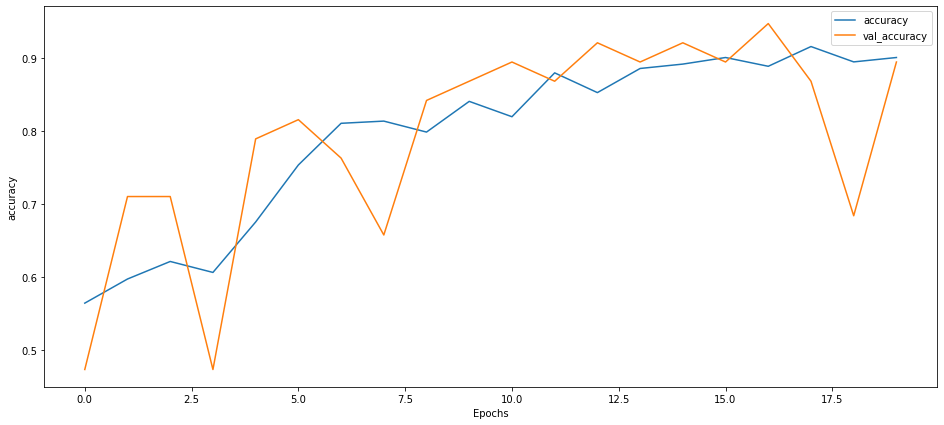

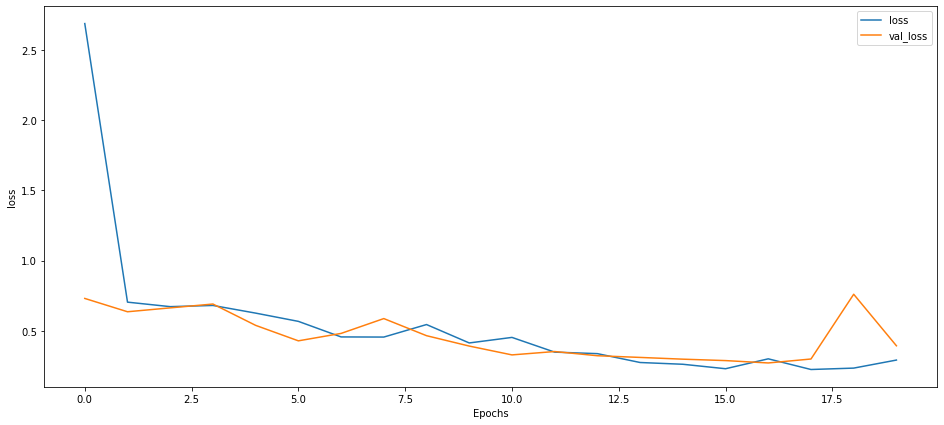

In [16]:
plot_graph(history,"accuracy")
plot_graph(history,"loss")

# save model 

In [21]:
model.save('bra_dection_mobileNetV2.h5')

# Test

In [157]:
pred = model.predict(X_val)

In [158]:
print(pred[1])
print(y_val[10])

[0.03383148 0.96616846]
[0. 1.]


# predict  images

In [160]:
img_size = 224

In [161]:
def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=[img_size, img_size]
    )

In [173]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(
        image_array[tf.newaxis, ...]
    )

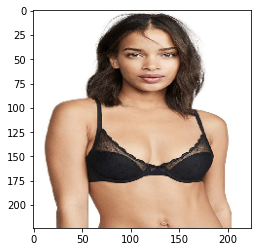

In [177]:
test_image_dir = './testsets'
test_images = []

for image in os.listdir(test_image_dir):
    # <PIL.Image.Image image mode=RGB size=224x224 at 0x141247ED0>
    test_image = load_image(os.path.join(TEST_IMAGES_DIR_PATH, image))
    test_image_array = image_to_array(test_image)
    test_images.append(test_image_array)
    display_image(test_image_array)

In [178]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [192]:
print('Image shape before preprocessing:', test_images[0].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

Image shape before preprocessing: (224, 224, 3)
Image shape after preprocessing: (1, 224, 224, 3)


In [180]:
print(test_images_preprocessed[0])

[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]]


In [181]:
def get_tags(probs, labels, max_classes = 2, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = unique_labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(np.int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [182]:
TEST_IMAGE_INDEX = 0

In [183]:
result = model(test_images_preprocessed[TEST_IMAGE_INDEX])

In [184]:
result.shape

TensorShape([1, 2])

In [185]:
print(result)

tf.Tensor([[0.5034199  0.49658018]], shape=(1, 2), dtype=float32)


In [186]:
np_result = result.numpy()[0]

In [187]:
print(np_result)

[0.5034199  0.49658018]


In [188]:
tags, labels_filtered, probs_filtered = get_tags(np_result, unique_labels)

In [189]:
print('probs_filtered:', probs_filtered)
print('labels_filtered:', labels_filtered)

probs_filtered: [50 49]
labels_filtered: ['with_bra' 'without_bra']


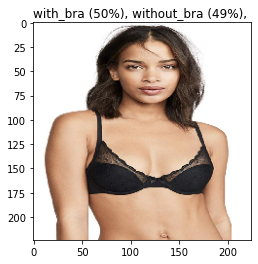

In [190]:
plt.figure()
plt.title(tags)
plt.imshow(test_image);

plt.show()